In [2]:
import numpy as np
import pandas as pd
import os
import data_processing as dp
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
import time
import h5py
import pywt
from scipy.fft import fft
from scipy import signal
from scipy.integrate import cumtrapz
from scipy import ndimage
from itertools import permutations,combinations
import matplotlib.pyplot as plt

In [ ]:
# Summarize labels in each file and save them to csv file

df = pd.DataFrame(index=[0,1,2,3,4,5,6])
for dirname,_,filenames in os.walk('E:\Document\教材\Master thesis\data'):
    for filename in filenames:
        dir_depth = len(dirname.split(os.path.sep))
        if dir_depth == 5:
            if filename.endswith('.csv'):
                file = os.path.join(dirname,filename)
                emg_data = pd.read_csv(file)
                try:
                    emg_data.Label2
                except AttributeError:
                    continue
                else:
                    info = emg_data.Label2.value_counts()
                    df[filename] = info
                print(info)
            #print(os.path.join(dirname,filename))
df.to_csv('whole_data_info.csv',index=True)
#df.to_csv('whole_data_info.txt',sep='\t',index=True)

In [6]:
# read file name of data with various Labels
df = pd.read_csv('./useful_data_label.csv',index_col=0) 
# read file name of data with only label 0
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
# read some of the data with only label 0
df3 = pd.read_csv('./data/file_name.txt',header=None)

In [4]:
width = 256
stride = 64
threshold_WAMP = 30
threshold_ZC = 0
threshold_SSC = 1
bins=9
bound = 100
HIST_range = (-bound,bound)

In [12]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [11]:
#generate features
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]

for width in widths:
    features = []
    labels = []
    stride = width//4
    for file in files:
        if file == ']]P379_M050_2_OFF_A_FoG_trial_1_emg.csv':
            continue
        print(file)
        feature,label = dp.pipeline_feature('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           show_para=False,
                                           filt=None)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    save_file = './processed data/nfeatures_W%d_S%d_WAMP30.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

G04_FoG_trial_1_emg.csv
G04_FoG_trial_2_emg.csv
G06_FoG_trial_1_emg.csv
G06_FoG_trial_2_emg.csv
G06_FoG_trial_3_emg.csv
G07_Freezing_Trial1_trial_1_emg.csv
G08_FoG_1_trial_1_emg.csv
G08_FoG_2_trial_1_emg.csv
G11_FoG_trial_1_emg.csv
G11_FoG_trial_2_emg.csv
P379_M050_2_OFF_A_FoG_trial_1_emg.csv
P379_M050_2_OFF_A_FoG_trial_2_emg.csv
P379_M050_2_OFF_A_FoG_trial_3_emg.csv
P379_M050_2_OFF_B_FoG_trial_1_emg.csv
P379_M050_2_OFF_B_FoG_trial_2_emg.csv
P379_M050_2_OFF_B_FoG_trial_3_emg.csv
P551_M050_2_A_FoG_trial_1_emg.csv
P551_M050_2_B_FoG_trial_1_emg.csv
P551_M050_2_B_FoG_trial_2_emg.csv
P812_M050_2_B_FoG_trial_1_emg.csv
P812_M050_2_B_FoG_trial_2_emg.csv
正常/G02_Walking_trial_1_emg.csv
正常/G03_Walking_trial_1_emg.csv
正常/G03_Walking_trial_2_emg.csv
正常/G05_Walking_struct_fixed_trial_1_emg.csv
正常/G05_Walking_struct_fixed_trial_3_emg.csv
正常/G09_FoG_trial_1_emg.csv
正常/G09_FoG_trial_3_emg.csv
正常/G11_Walking_trial_2_emg.csv
正常/P231_M050_A_Walking_trial_2_emg.csv
正常/P231_M050_A_Walking_trial_4_emg.csv
正常

In [12]:
#generate features of the rest data
ind = df2.iloc[1].isna()
files = df2.columns[ind]
widths = [256]
i = 0
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = {'Left':cols[:4],'Right':cols[4:]}
data = False
if data:
    for width in widths:
        X = []
        Y = []
        stride = width//4
        for file in files:
            if file in np.array(df3):
                i += 1
                print('skip')
                continue
            print(file)
            emg_data = pd.read_csv('./data/正常/'+file)
            emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
                                        'LEFT_TS':emg_data.LEFT_TS.mean(),
                                        'LEFT_BF':emg_data.LEFT_BF.mean(),
                                        'LEFT_RF':emg_data.LEFT_RF.mean(),
                                        'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                                        'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                                        'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                                        'RIGHT_RF':emg_data.RIGHT_RF.mean()})
            #emg_data = emg_data[emg_data.Label1 == emg_data.Label2].reset_index(drop=True)
            x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=False)
            X += x.tolist()
            Y += y.tolist()
        print('save...')
        print(stride)
        file = './processed data/data_set_after_window_S64_rest.hdf5'
        with h5py.File(file,'w') as f:
            f.create_dataset('cwt_data',data=np.array(X),
                             chunks = True,dtype = np.float32)
            f.create_dataset('label2',data=np.array(Y), dtype = np.int8)
        print('save finished.')
        print(i)
else:
    for width in widths:
        features = []
        labels = []
        stride = width//4
        for file in files:
            if file in np.array(df3):
                i += 1
                print('skip')
                continue
            print(file)
            feature,label = dp.pipeline_feature('./data/正常/'+file,
                                               #columns = cols['Right'],
                                               width = width, 
                                               stride=stride,
                                               threshold_WAMP = threshold_WAMP,
                                               threshold_SSC = threshold_SSC,
                                               bins=bins,
                                               ranges=HIST_range,
                                               show_para=False)
            features += feature.tolist()
            labels += label.tolist()
        print('save...')
        print(stride)
        save_file = './processed data/nfeatures_rest_W%d_S%d.hdf5'%(width,stride)
        with h5py.File(save_file,'w') as f:
            f.create_dataset('features',data=np.array(features),
                             chunks = True,dtype = np.float32)
            f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
        print('save finished.')
        print(i)

skip
skip
skip
skip
G05_Walking_struct_fixed_trial_2_emg.csv
skip
skip
G09_FoG_trial_2_emg.csv
skip
G09_Walking_trial_2_emg.csv
G09_Walking_trial_4_emg.csv
G09_Walking_trial_6_emg.csv
skip
G11_Walking_trial_4_emg.csv
skip
skip
P231_M050_A_Walking_trial_6_emg.csv
P231_M050_B_Walking_trial_2_emg.csv
P231_M050_B_Walking_trial_4_emg.csv
P231_M050_B_Walking_trial_6_emg.csv
P231_M100_2_A_FoG_trial_3_emg.csv
P231_M100_2_A_Walking_trial_4_emg.csv
P231_M100_2_A_Walking_trial_6_emg.csv
P231_M100_ON_A_Walking_trial_2_emg.csv
P231_M100_ON_A_Walking_trial_4_emg.csv
P231_M100_ON_A_Walking_trial_6_emg.csv
P231_Msham_A_Walking_trial_2_emg.csv
P231_Msham_A_Walking_trial_6_emg.csv
P231_Msham_B_Walking_trial_2_emg.csv
skip
P351_M050_2_A_FoG_trial_2_emg.csv
P351_M050_2_A_FoG_trial_3_emg.csv
skip
P351_M050_2_A_Walking_trial_4_emg.csv
P351_M050_2_A_Walking_trial_6_emg.csv
P351_M050_2_B_FoG_trial_1_emg.csv
P351_M050_2_B_FoG_trial_2_emg.csv
P351_M050_2_B_FoG_trial_3_emg.csv
P351_M050_2_B_Walking_trial_2_emg.c

In [77]:
np.array(features).shape

(53005, 84)

In [264]:
#generate features from Left or Right
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]
#drop_cols = [ 'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = {'Left':cols[:4],'Right':cols[4:]}
for col in cols:
    features = []
    labels = []
    stride = width//4
    for file in files:
        feature,label = dp.pipeline_selected_feature('./data/'+file,
                                                     columns=cols[col],
                                            width = width, 
                                           stride=stride,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           show_para=False)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    #save_file = './processed data/'+col+'_features_W%d_S%d.hdf5'%(width,stride)
    save_file = './processed data/'+col+'_nfeatures_W%d_S%d.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

save...
64
save finished.
save...
64
save finished.


In [90]:
#generate selected features
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]
cols = ['LTA','LTS','LBF','LRF','RTA','RTS','RBF','RRF']
#drop_cols = [ 'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = 
for p in combinations(cols,2):
#for col in cols:
    features = []
    labels = []
    width = 256
    stride = width//4
    #col = [p[0],p[1]]
    for file in files:
        feature,label = dp.pipeline_selected_feature('./data/'+file,
                                                     #columns=col,
                                                     drop_cols = [col],
                                            width = width, 
                                           stride=stride,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           show_para=False)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    #save_file = './processed data/'+p[0]+p[1]+'_features_W%d_S%d.hdf5'%(width,stride)
    save_file = './processed data/drop_'+col+'_features_W%d_S%d.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.


In [6]:
np.array(features).shape

(34360, 42)

In [34]:
cols = ['LTA','LTS','LBF','LRF','RTA','RTS','RBF','RRF']
cols = {'Left':cols[:4],'Right':cols[4:]}
for col in cols:
    print(cols[col])

['LTA', 'LTS', 'LBF', 'LRF']
['RTA', 'RTS', 'RBF', 'RRF']


In [5]:
(num-256)/32

0    14576.34375
1     9322.81250
2    15632.78125
3     1228.59375
4       65.81250
5       -8.00000
6     7140.87500
dtype: float64

In [15]:
width = 256
stride = 32
threshold_WAMP = 30
threshold_ZC = 0
threshold_SSC = 1
bins=9
bound = 150
HIST_range = (-bound,bound)

In [163]:
# read the data and labels
#files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
files = np.array(df.columns)
X = []
Y = []
#sc = StandardScaler(with_mean=False)
i = 0
start = time.time()
for file in files:
    emg_data = pd.read_csv('./data/'+file)
    #emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
    #                            'LEFT_TS':emg_data.LEFT_TS.mean(),
    #                            'LEFT_BF':emg_data.LEFT_BF.mean(),
    #                            'LEFT_RF':emg_data.LEFT_RF.mean(),
    #                            'RIGHT_TA':emg_data.RIGHT_TA.mean(),
    #                            'RIGHT_TS':emg_data.RIGHT_TS.mean(),
    #                            'RIGHT_BF':emg_data.RIGHT_BF.mean(),
    #                            'RIGHT_RF':emg_data.RIGHT_RF.mean()})
    #emg_data = emg_data[emg_data.Label1 == emg_data.Label2].reset_index(drop=True)
    emg_data = emg_data.dropna().reset_index(drop=True)
    x = np.array(emg_data.iloc[:,3:])
    y = np.array(emg_data.Label2)
    #x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=False,same_label=True)
    X += x.tolist()
    Y += y.tolist()
    i += 1
    print('i:%d'%i,x.shape)
end = time.time()
duration = end-start
print('Duration: %f'%(duration))

i:1 (16583, 8)
i:2 (4489, 8)
i:3 (35121, 8)
i:4 (31027, 8)
i:5 (30783, 8)
i:6 (159539, 8)
i:7 (225455, 8)
i:8 (362273, 8)
i:9 (28868, 8)
i:10 (20878, 8)
i:11 (25322, 8)
i:12 (24242, 8)
i:13 (21728, 8)
i:14 (27916, 8)
i:15 (27146, 8)
i:16 (25947, 8)
i:17 (26203, 8)
i:18 (89500, 8)
i:19 (70282, 8)
i:20 (79595, 8)
i:21 (73280, 8)
Duration: 3.091342


In [89]:
X=np.array(X)
Y=np.array(Y)
Y.shape

(2343365,)

In [30]:
# read the data and labels of df2 or df3
sc = StandardScaler()
sc = MinMaxScaler()
ind = df2.iloc[1].isna()
#files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
files = np.array(df.columns)
N = len(files)
#sc = StandardScaler(with_mean=False)
width = 256
stride = 64
start = time.time()
i = 0
X = []
Y = []
F = []

for file in files:
    #if file in np.array(df3.loc[:,0]):
    #    continue
    i += 1
    emg_data = pd.read_csv('./data/'+file)
    #emg_data.iloc[:,3:] = 
    emg_data = emg_data.dropna().reset_index(drop=True)
    emg_data.iloc[:,3:]=normalize(emg_data.iloc[:,3:])
    #emg_data.iloc[:,3:] = sc.fit_transform(emg_data.iloc[:,3:])
    #fn = 20
    #wn=2*fn/1000
    #fn1 = 400
    #wn1 = 2*fn1/1000
    #b, a = signal.butter(4, wn1, 'lowpass')
    #for j in ['LEFT_TA','LEFT_TS','LEFT_BF','LEFT_RF','RIGHT_TA','RIGHT_TS','RIGHT_BF','RIGHT_RF']:
        #emg_data.loc[:,j] = signal.filtfilt(b, a, emg_data.loc[:,j])
    x,y = dp.generate_window_slide_data(emg_data,width=width,
                                        stride=stride,
                                        scaler=False,
                                        same_label=True)
    #x=np.abs(x)
    #x=dp.lowpass_filter(x,300)

    fi = [file]*len(x)
    X += x.tolist()
    Y += y.tolist()
    F += fi
    print('%d/%d: '%(i,N)+file)
    
end = time.time()
duration = end-start
print('Duration: %f'%(duration))

1/21: G04_FoG_trial_1_emg.csv
2/21: G04_FoG_trial_2_emg.csv
3/21: G06_FoG_trial_1_emg.csv
4/21: G06_FoG_trial_2_emg.csv
5/21: G06_FoG_trial_3_emg.csv
6/21: G07_Freezing_Trial1_trial_1_emg.csv
7/21: G08_FoG_1_trial_1_emg.csv
8/21: G08_FoG_2_trial_1_emg.csv
9/21: G11_FoG_trial_1_emg.csv
10/21: G11_FoG_trial_2_emg.csv
11/21: P379_M050_2_OFF_A_FoG_trial_1_emg.csv
12/21: P379_M050_2_OFF_A_FoG_trial_2_emg.csv
13/21: P379_M050_2_OFF_A_FoG_trial_3_emg.csv
14/21: P379_M050_2_OFF_B_FoG_trial_1_emg.csv
15/21: P379_M050_2_OFF_B_FoG_trial_2_emg.csv
16/21: P379_M050_2_OFF_B_FoG_trial_3_emg.csv
17/21: P551_M050_2_A_FoG_trial_1_emg.csv
18/21: P551_M050_2_B_FoG_trial_1_emg.csv
19/21: P551_M050_2_B_FoG_trial_2_emg.csv
20/21: P812_M050_2_B_FoG_trial_1_emg.csv
21/21: P812_M050_2_B_FoG_trial_2_emg.csv
Duration: 28.266805


In [52]:
test = np.array([['ss','s']])
dt = h5py.special_dtype(vlen=str)
file = './processed data/test.hdf5'
with h5py.File(file,'w') as f:
    aa = f.create_dataset('data',test.shape,dtype=dt)
    aa[:] = test
test

array([['ss', 's']], dtype='<U2')

In [32]:
files = np.concatenate([np.array(df.columns),np.array(df3.loc[:,0])])
file = './processed data/data_set_after_window_S256_all_sameLabel.hdf5'
file2 = './processed data/cwt_mexh_W256_S256_WS32_allPa_sameLabel.hdf5'
dt = h5py.special_dtype(vlen=str)
with h5py.File(file,'r') as f:
    da = f['data'].shape
    l = da[0]
    #ind = f['file'][...].map(lambda x : x in files)
    ind = list(map(lambda x : x in files, f['file']))
    ind = np.where(np.array(ind) == True)
    #print(list(ind))
    print(f['data'][ind].shape)
    y = f['label2'][ind]
    cwtmatr = dp.generate_CWT_feature(f['data'][ind],wavelet='mexh')
    ff = f['file'][ind]
    with h5py.File(file2,'w') as f2:
        f2.create_dataset('feature',data=cwtmatr,
                         chunks = True, dtype = np.float32)
        f2.create_dataset('label',data=y,dtype=np.int8)
        #da = f.create_dataset('file',np.array(ff).shape,dtype=dt)
        #da[:] = ff
    #for i in range(4):
        #temp = f['data'][i*l//4:(i+1)*l//4]
        #print(i*l//4,(i+1)*l//4)

(4034, 256, 8)


In [55]:
pd.Series(y).value_counts()

0    5400
2    5348
6    2941
1    2370
3      47
dtype: int64

In [31]:
dt = h5py.special_dtype(vlen=str)
file = './processed data/data_set_after_window_W256_S64_sameLabel_nm.hdf5'
with h5py.File(file,'w') as f:
    f.create_dataset('data',data=X,
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=Y, dtype = np.int8)
    da = f.create_dataset('file',np.array(F).shape,dtype=dt)
    da[:] = F

In [21]:
#generate cwt features
#files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]
files=np.array(df.columns)
for width in widths:
    features = []
    labels = []
    #stride = width//4
    save_file = './processed data/cwt_W%d_S%d_Wc32_mexh_nm_no_G08_FoG_1_trial_1.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        temp1=f.create_dataset('features',(26513,32,256,8),
                         chunks = True,dtype = np.float32)
        temp2=f.create_dataset('labels',(26513,), dtype = np.int8)
        i = 0
        ls = 0
        for file in files:
            if file == 'G08_FoG_1_trial_1_emg.csv':
                continue
            print(file)
            feature,label = dp.pipeline_cwt('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           norm=True,
                                           width_c=32,
                                       same_label=True,
                                           dropna=True,
                                           filt=None)
            l = len(label)
            print(i,':',l)
            temp1[ls:(ls+l)]=feature
            temp2[ls:(ls+l)]=label
            ls+=l
            i+=1
        print(ls)
        #features += feature.tolist()
        #labels += label.tolist()
    #print('save...')
    #print(stride)
    #save_file = './processed data/cwt_W%d_S%d_Wc32_mexh.hdf5'%(width,stride)
    #with h5py.File(save_file,'w') as f:
    #    f.create_dataset('features',data=np.array(features),
    #                     chunks = True,dtype = np.float32)
    #    f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

G04_FoG_trial_1_emg.csv
0 : 384
G04_FoG_trial_2_emg.csv
1 : 133
G06_FoG_trial_1_emg.csv
2 : 1013
G06_FoG_trial_2_emg.csv
3 : 867
G06_FoG_trial_3_emg.csv
4 : 897
G07_Freezing_Trial1_trial_1_emg.csv
5 : 3466
G08_FoG_2_trial_1_emg.csv
6 : 7420
G11_FoG_trial_1_emg.csv
7 : 790
G11_FoG_trial_2_emg.csv
8 : 603
P379_M050_2_OFF_A_FoG_trial_1_emg.csv
9 : 631
P379_M050_2_OFF_A_FoG_trial_2_emg.csv
10 : 377
P379_M050_2_OFF_A_FoG_trial_3_emg.csv
11 : 596
P379_M050_2_OFF_B_FoG_trial_1_emg.csv
12 : 584
P379_M050_2_OFF_B_FoG_trial_2_emg.csv
13 : 652
P379_M050_2_OFF_B_FoG_trial_3_emg.csv
14 : 643
P551_M050_2_A_FoG_trial_1_emg.csv
15 : 516
P551_M050_2_B_FoG_trial_1_emg.csv
16 : 2217
P551_M050_2_B_FoG_trial_2_emg.csv
17 : 1580
P812_M050_2_B_FoG_trial_1_emg.csv
18 : 1660
P812_M050_2_B_FoG_trial_2_emg.csv
19 : 1484
26513
save finished.


In [20]:
16106

26513

In [25]:
with h5py.File('./test.hdf5','w') as f:
    f.create_dataset('features',data=np.random.randint(0,10,(3,5,5)),maxshape=[None,5,5],
                         chunks = True,dtype = np.float32)
for i in range(3):
    with h5py.File('./test.hdf5','a') as f:
        temp = f['features']
        print((i+3)*3)
        temp[(i+3)*3:(i+4)*3,:,:] = np.random.randint(0,10,(3,5,5))

9
12
15


In [22]:
with h5py.File('./test.hdf5','r') as f:
    print(f['features'][...])

[[[2. 1. 3. 3. 0.]
  [3. 2. 0. 8. 6.]
  [1. 9. 6. 9. 0.]
  [5. 8. 8. 1. 7.]
  [7. 9. 2. 7. 4.]]

 [[1. 1. 4. 6. 0.]
  [7. 6. 0. 8. 2.]
  [1. 8. 8. 1. 9.]
  [8. 7. 3. 9. 1.]
  [2. 4. 0. 8. 9.]]

 [[2. 3. 6. 5. 4.]
  [6. 5. 8. 9. 5.]
  [2. 1. 1. 1. 5.]
  [4. 9. 7. 7. 4.]
  [7. 1. 0. 5. 0.]]]


In [22]:
width = 256
stride = 64
threshold_WAMP = 30
threshold_ZC = 0
threshold_SSC = 1
bins=9
bound = 70
HIST_range = (-bound,bound)
fbins=3
fbound = 300
frange = (0,fbound)
threshold_F = 10
num=3

In [160]:
stride

64

In [23]:
# save all feature as dataframe
ind = df2.iloc[1].isna()
#files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
files = np.array(df.columns)
widths = [256]
N = len(files)
i = 0
for width in widths:
    features = []
    labels = []
    #stride = width//4
    Data = pd.DataFrame()
    for file in files:
        i += 1
        #print(file)
        drop, data = dp.pipeline_feature_pd('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           fbins=fbins,
                                            franges=frange,
                                            threshold_F=threshold_F,
                                            num=num,
                                           level=None,
                                           filt=None,
                                           drop_na=True,
                                           same_label=True)
        if drop:
            print('%d/%d drop: '%(i,N)+file)
            continue
        print('%d/%d: '%(i,N)+file)
        Data = pd.concat([Data,data])
    print('save...')
    print(stride)
    #save_file = './processed data/nfeatures_W%d_S%d_WAMP30.hdf5'%(width,stride)
    #with h5py.File(save_file,'w') as f:
    #    f.create_dataset('features',data=np.array(features),
    #                     chunks = True,dtype = np.float32)
    #    f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

1/21: G04_FoG_trial_1_emg.csv
2/21: G04_FoG_trial_2_emg.csv
3/21: G06_FoG_trial_1_emg.csv
4/21: G06_FoG_trial_2_emg.csv
5/21: G06_FoG_trial_3_emg.csv
6/21: G07_Freezing_Trial1_trial_1_emg.csv
7/21: G08_FoG_1_trial_1_emg.csv
8/21: G08_FoG_2_trial_1_emg.csv
9/21: G11_FoG_trial_1_emg.csv
10/21: G11_FoG_trial_2_emg.csv
11/21: P379_M050_2_OFF_A_FoG_trial_1_emg.csv
12/21: P379_M050_2_OFF_A_FoG_trial_2_emg.csv
13/21: P379_M050_2_OFF_A_FoG_trial_3_emg.csv
14/21: P379_M050_2_OFF_B_FoG_trial_1_emg.csv
15/21: P379_M050_2_OFF_B_FoG_trial_2_emg.csv
16/21: P379_M050_2_OFF_B_FoG_trial_3_emg.csv
17/21: P551_M050_2_A_FoG_trial_1_emg.csv
18/21: P551_M050_2_B_FoG_trial_1_emg.csv
19/21: P551_M050_2_B_FoG_trial_2_emg.csv
20/21: P812_M050_2_B_FoG_trial_1_emg.csv
21/21: P812_M050_2_B_FoG_trial_2_emg.csv
save...
64
save finished.


In [ ]:
# save DWT as dataframe
ind = df2.iloc[1].isna()
files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
widths = [256]
N = len(files)
i = 0
for width in widths:
    features = []
    labels = []
    stride = width//4
    Data = pd.DataFrame()
    for file in files:
        i += 1
        #print(file)
        data = dp.pipeline_dwt('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,)

        print('%d/%d: '%(i,N)+file)
        Data = pd.concat([Data,data])
    print('save...')
    print(stride)
    #save_file = './processed data/nfeatures_W%d_S%d_WAMP30.hdf5'%(width,stride)
    #with h5py.File(save_file,'w') as f:
    #    f.create_dataset('features',data=np.array(features),
    #                     chunks = True,dtype = np.float32)
    #    f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

In [7]:
# save CWT feature as dataframe
ind = df2.iloc[1].isna()
files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
widths = [256]
N = len(files)
i = 0
for width in widths:
    features = []
    labels = []
    #stride = width//4
    Data = pd.DataFrame()
    for file in files:
        i += 1
        #print(file)
        data = dp.pipeline_cwt_feature('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           scale = 32,
                                           filt=None,
                                           same_label=True)

        print('%d/%d: '%(i,N)+file)
        Data = pd.concat([Data,data])
    print('save...')
    print(stride)
    #save_file = './processed data/nfeatures_W%d_S%d_WAMP30.hdf5'%(width,stride)
    #with h5py.File(save_file,'w') as f:
    #    f.create_dataset('features',data=np.array(features),
    #                     chunks = True,dtype = np.float32)
    #    f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

1/174: G04_FoG_trial_1_emg.csv
2/174: G04_FoG_trial_2_emg.csv
3/174: G06_FoG_trial_1_emg.csv
4/174: G06_FoG_trial_2_emg.csv


KeyboardInterrupt: 

In [12]:
with h5py.File('./test.hdf5','w') as f:
    temp = f.create_dataset('feature',(3,3,3))
    for i in range(3):
        temp[i*3:(i+1)*3] = np.random.randint(0,10,(3,3,3))

In [13]:
with h5py.File('./test.hdf5','r') as f:
    print(f['feature'][...])

[[[6. 1. 5.]
  [5. 3. 8.]
  [9. 9. 1.]]

 [[1. 7. 4.]
  [2. 3. 8.]
  [8. 1. 3.]]

 [[5. 4. 3.]
  [0. 0. 6.]
  [6. 7. 8.]]]


In [24]:
Data.to_csv('./processed data/dataframe_W256_S64_R180_DWTLmax_dropna_samelabel_MF3.csv',index=False)

In [84]:
Data1 = pd.read_csv('./processed data/dataframe_W256_S64_R180_dropna_DWTLmax_samelabel.csv')
Data2 = pd.read_csv('./processed data/cwtf_W256_S64_WS32_dropna_samelabel.csv')

In [22]:
#ind=Data.isna().sum()!=0
#Data.loc[:,ind].isna().sum()
#Data

In [85]:
Data1.iloc[:,:-1].join(Data2.iloc[:,1:-1]).join(Data1.File).to_csv('./processed data/featurePcwtf_W256_S64_WS32_R180_DWTLmax_dropna_samelabel.csv',index=False)

In [14]:
file = './processed data/data_set_after_window_S64_allPa.hdf5'
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=np.array(X),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=np.array(Y), dtype = np.int8)

In [38]:
file = './processed data/feature_restdata.hdf5'
with h5py.File(file,'w') as f:
    f.create_dataset('features',data=np.array(features),
                     chunks = True,dtype = np.float32)
    f.create_dataset('labels',data=np.array(Y), dtype = np.int8)

In [31]:
emg_data[emg_data.Label1 == emg_data.Label2].Label1.value_counts()

0    26775
2    22889
1     2842
3      761
Name: Label1, dtype: int64

In [69]:
if file in np.array(df3):
    print('yes')
file
df3.iloc[:,0]

yes


0                  G02_Walking_trial_1_emg.csv
1                  G03_Walking_trial_1_emg.csv
2                  G03_Walking_trial_2_emg.csv
3     G05_Walking_struct_fixed_trial_1_emg.csv
4     G05_Walking_struct_fixed_trial_3_emg.csv
5                      G09_FoG_trial_1_emg.csv
6                      G09_FoG_trial_3_emg.csv
7                  G11_Walking_trial_2_emg.csv
8          P231_M050_A_Walking_trial_2_emg.csv
9          P231_M050_A_Walking_trial_4_emg.csv
10           P351_M050_2_A_FoG_trial_1_emg.csv
11       P351_M050_2_A_Walking_trial_2_emg.csv
12        P351_Msham_B_Walking_trial_6_emg.csv
13         P379_M050_A_Walking_trial_2_emg.csv
14        P379_Msham_B_Walking_trial_6_emg.csv
15         P533_M050_A_Walking_trial_2_emg.csv
16         P533_M050_B_Walking_trial_3_emg.csv
17       P623_M050_2_A_Walking_trial_2_emg.csv
18         P623_M100_A_Walking_trial_4_emg.csv
19         P645_M050_A_Walking_trial_2_emg.csv
20         P645_M050_B_Walking_trial_2_emg.csv
21           

In [112]:
path = './processed data/data_set_after_window_label12.hdf5'
with h5py.File(path,'r') as f:
    x = f['cwt_data'][...]
    y = f['label2'][...]

2    11903
0    11711
6     5887
1     5405
3       92
dtype: int64

In [9]:
emg_data = pd.read_csv('.\\data\\正常\\P231_Msham_B_Walking_trial_2_emg.csv')
emg_data = emg_data.dropna().reset_index(drop=True)
#emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
#                            'LEFT_TS':emg_data.LEFT_TS.mean(),
#                            'LEFT_BF':emg_data.LEFT_BF.mean(),
#                            'LEFT_RF':emg_data.LEFT_RF.mean(),
#                            'RIGHT_TA':emg_data.RIGHT_TA.mean(),
#                            'RIGHT_TS':emg_data.RIGHT_TS.mean(),
#                            'RIGHT_BF':emg_data.RIGHT_BF.mean(),
#                            'RIGHT_RF':emg_data.RIGHT_RF.mean()})
x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=False,same_label=True)
#x = np.clip(x,-500,500)
x = np.abs(x)
x_filter = dp.lowpass_filter(x,100)

In [154]:
temp=dp.pipeline_feature_pd('.\data\G06_FoG_trial_1_emg.csv',
                             width = width, 
                             stride=stride,
                             threshold_WAMP = threshold_WAMP,
                             threshold_SSC = threshold_SSC,
                             bins=bins,
                             ranges=HIST_range)

In [113]:
ind = (emg_data.Label1==emg_data.Label2)
emg_data.loc[ind,:].shape

(58233, 11)

In [7]:
pd.Series(y).value_counts()

2    478
0    291
1     50
3     11
dtype: int64

In [39]:
#dp.compute_FHIST_pd(x,threshold=0.5)
compute_MaxFreq(x)

,LEFT_TA_MF0,LEFT_TA_MF1,LEFT_TA_MF2,LEFT_TS_MF0,LEFT_TS_MF1,LEFT_TS_MF2,LEFT_BF_MF0,LEFT_BF_MF1,LEFT_BF_MF2,LEFT_RF_MF0,...,RIGHT_TA_MF2,RIGHT_TS_MF0,RIGHT_TS_MF1,RIGHT_TS_MF2,RIGHT_BF_MF0,RIGHT_BF_MF1,RIGHT_BF_MF2,RIGHT_RF_MF0,RIGHT_RF_MF1,RIGHT_RF_MF2
0,97.65625,35.15625,105.46875,46.87500,246.09375,273.43750,109.37500,128.90625,27.34375,42.96875,...,101.56250,125.00000,292.96875,97.65625,109.37500,210.93750,347.65625,78.12500,85.93750,42.96875
1,97.65625,35.15625,101.56250,82.03125,46.87500,250.00000,101.56250,164.06250,125.00000,42.96875,...,93.75000,97.65625,35.15625,50.78125,347.65625,54.68750,78.12500,78.12500,42.96875,74.21875
2,39.06250,93.75000,97.65625,62.50000,54.68750,82.03125,97.65625,66.40625,113.28125,121.09375,...,70.31250,50.78125,242.18750,11.71875,82.03125,445.31250,144.53125,78.12500,85.93750,93.75000
3,93.75000,97.65625,31.25000,62.50000,54.68750,50.78125,66.40625,410.15625,296.87500,46.87500,...,101.56250,97.65625,50.78125,62.50000,109.37500,82.03125,144.53125,85.93750,78.12500,70.31250
4,70.31250,66.40625,50.78125,50.78125,113.28125,58.59375,66.40625,62.50000,35.15625,58.59375,...,82.03125,97.65625,15.62500,50.78125,50.78125,195.31250,109.37500,74.21875,50.78125,70.31250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,27.34375,117.18750,105.46875,11.71875,93.75000,152.34375,42.96875,85.93750,62.50000,62.50000,...,19.53125,54.68750,101.56250,132.81250,54.68750,167.96875,78.12500,97.65625,66.40625,93.75000
394,27.34375,89.84375,46.87500,54.68750,58.59375,11.71875,85.93750,42.96875,70.31250,70.31250,...,19.53125,89.84375,101.56250,132.81250,70.31250,148.43750,335.93750,97.65625,85.93750,113.28125
395,23.43750,89.84375,50.78125,58.59375,27.34375,62.50000,39.06250,105.46875,82.03125,58.59375,...,101.56250,89.84375,132.81250,105.46875,335.93750,50.78125,214.84375,97.65625,54.68750,89.84375
396,42.96875,62.50000,39.06250,58.59375,27.34375,70.31250,70.31250,39.06250,85.93750,70.31250,...,62.50000,89.84375,105.46875,132.81250,214.84375,35.15625,109.37500,109.37500,66.40625,54.68750


In [25]:
sc = StandardScaler(with_mean=False)
#sc = MinMaxScaler()
x_sc = sc.fit_transform(np.reshape(x,(-1,256*8)))
x_sc = np.reshape(x_sc,(-1,256,8))
x_filter_sc = dp.lowpass_filter(x_sc,100)

In [6]:
fn = 300
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
x_filter = signal.filtfilt(b, a, x[1,:,1])

In [26]:
N=256
T=1/1000
data = x_filter[250,:,5]
data1 = x[250,:,5]
yf = fft(data)
yff = 2.0/N * np.abs(yf[0:N//2])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
total = (cumtrapz(yff,xf))
w=np.where(total>=(total[-1]/2))[0][0]

yf1 = fft(data1)
yff1 = 2.0/N * np.abs(yf1[0:N//2])
xf1 = np.linspace(0.0, 1.0/(2.0*T), N//2)
total1 = (cumtrapz(yff1,xf1))
w1=np.where(total1>=(total1[-1]/2))[0][0]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


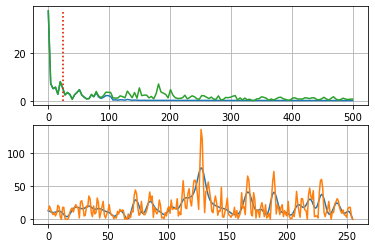

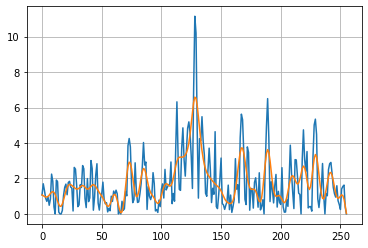

In [28]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(xf, yff)
plt.plot([xf[w],xf[w]],[0,yff.max()],linestyle=':')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data)
plt.grid(True)
#plt.figure()
plt.subplot(2,1,1)
plt.plot(xf1, yff1)
plt.plot([xf1[w],xf1[w]],[0,yff1.max()],linestyle=':')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data1)
plt.grid(True)
plt.figure()
plt.plot(x_sc[250,:,5])
plt.plot(x_filter_sc[250,:,5])
plt.grid(True)

In [171]:
'./data/P812_M050_2_B_FoG_trial_2_emg.csv'.split('/')[-1]

'P812_M050_2_B_FoG_trial_2_emg.csv'

In [172]:
emg_data.columns

Index(['Time', 'Label1', 'Label2', 'LEFT_TA', 'LEFT_TS', 'LEFT_BF', 'LEFT_RF',
       'RIGHT_TA', 'RIGHT_TS', 'RIGHT_BF', 'RIGHT_RF'],
      dtype='object')

In [28]:
data = x[354,:,2]
freqs, power=signal.periodogram(data, 1e3)
total = (cumtrapz(power,freqs))
w=np.where(total>=(total[-1]/2))[0][0]
yf = fft(np.array(data))
yff = 2.0/len(data) * np.abs(yf[0:len(data)//2])
xf = np.linspace(0.0, 1.0/(2.0*T), len(data)//2)

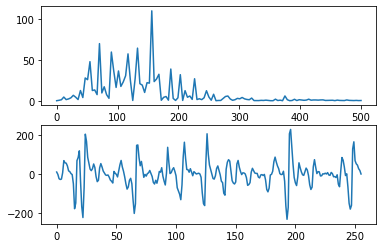

In [29]:
#sc = MinMaxScaler((0,1))
#power = sc.fit_transform(np.reshape(power,(-1,1)))
plt.subplot(2,1,1)
plt.plot(freqs, power)
plt.subplot(2,1,2)
plt.plot(data)

In [35]:
ind = np.argsort(-power)[:3]
freqs[ind]
#hist,_ = np.histogram(freqs[ind[:,0]],bins=5,range=(0,200))
#plt.hist(freqs[ind[:,0]],bins=3,range=(0,200))

array([156.25  ,  70.3125, 132.8125])

In [38]:
feature_col = ['_IEMG','_MAV','_SSI','_VAR','_RMS',
               '_WL','_ZC','_SSC','_WAMP','_skew','_Acti','_AR','_HIST','_MDF']
ind = Data.columns.str.contains('_SSI')
Data.iloc[:,ind].max()

LEFT_TA_SSI     5.366227e+07
LEFT_TS_SSI     2.340434e+08
LEFT_BF_SSI     7.869578e+08
LEFT_RF_SSI     5.972622e+08
RIGHT_TA_SSI    5.507855e+07
RIGHT_TS_SSI    1.321042e+09
RIGHT_BF_SSI    4.847253e+07
RIGHT_RF_SSI    1.949695e+08
dtype: float32

5


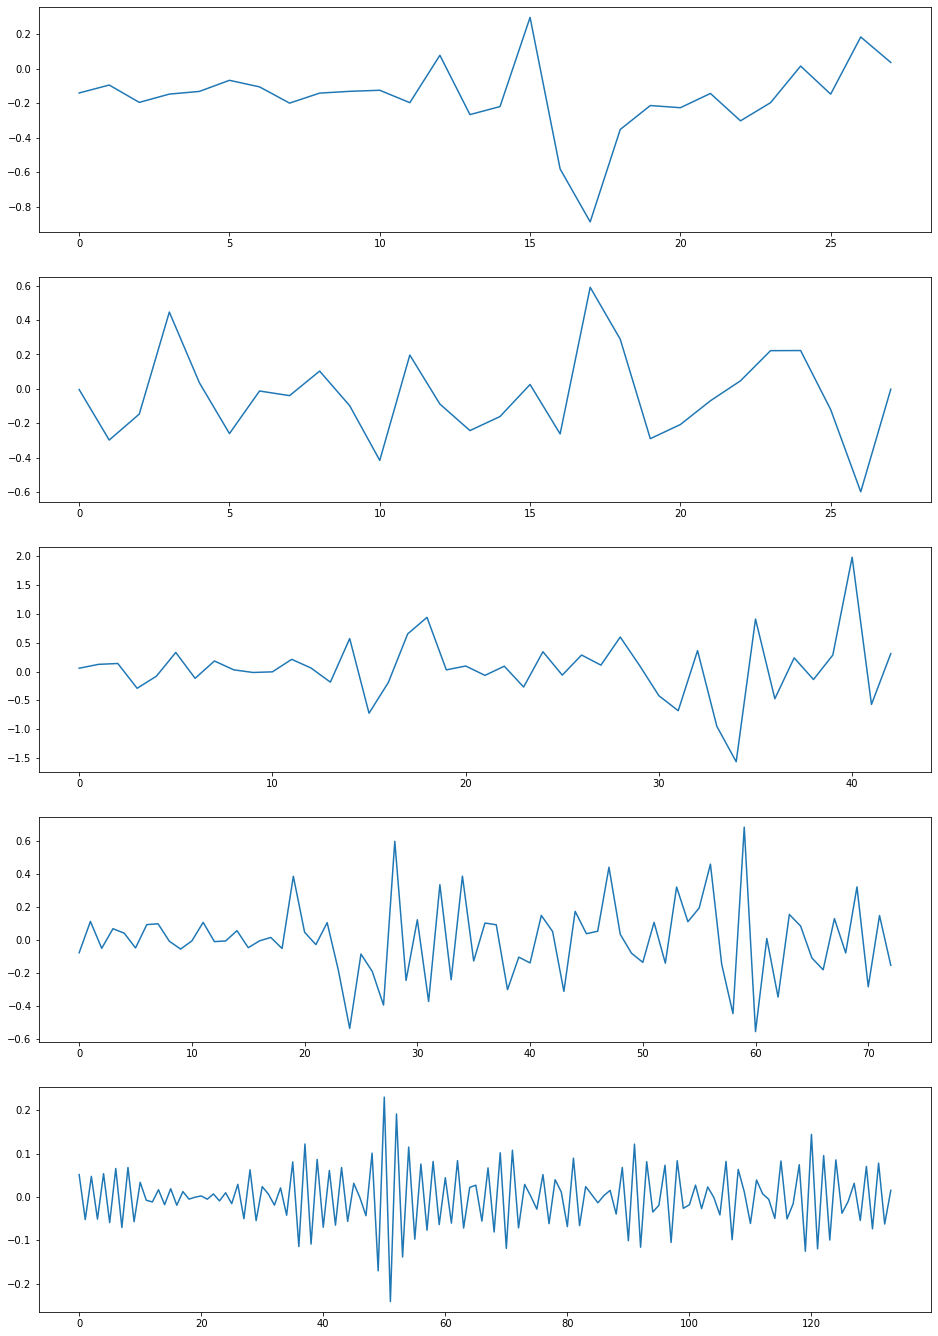

In [79]:
#data = emg_data.LEFT_TS
plt.figure(figsize=(16,24))
wa = pywt.wavedec(data,'db7',level=None)
j = 0
for i in wa:
    j += 1
    plt.subplot(len(wa),1,j)
    plt.plot(i)
print(len(wa))    

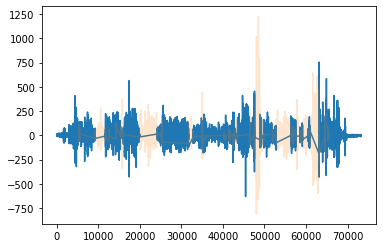

In [88]:
ind = emg_data.Label2==emg_data.Label1
plt.plot(emg_data.LEFT_RF[ind])
plt.plot(emg_data.LEFT_RF[~ind],alpha=0.2)

In [21]:
Data.iloc[1,:-2]

LEFT_TA_0          -7.77079
LEFT_TA_1          -7.79597
LEFT_TA_2          -7.82115
LEFT_TA_3          -7.84627
LEFT_TA_4          -7.86993
                   ...     
RIGHT_RF_301      -0.148881
RIGHT_RF_302      0.0168772
RIGHT_RF_303      0.0204935
RIGHT_RF_304       -0.00682
RIGHT_RF_305    1.95578e-08
Name: 1, Length: 2448, dtype: object

In [38]:
def mDWT(data):
    wa = pywt.wavedec(data,'db7',3)
    wa = np.concatenate(wa)
    N = len(wa)
    S = int(np.log2(N))
    M = []
    for i in range(S):
        C = N//(2**(i+1))-1
        #print(C)
        M.append(np.abs(wa[:C+1]).sum())
    return M
    
def compute_mDWT(data):
    N,M = data.shape[0::2]
    feature = []
    for i in range(N):
        temp = []
        for j in range(M):
            temp.extend(mDWT(data[i,:,j]))
        feature.append(temp)
    return feature

#import warnings  
#warnings.filterwarnings('error') 

def compute_MNF(data):
    N,M = data.shape[0::2]
    feature = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            freqs, power=signal.periodogram(data[i,:,j], 1e3)
            try:
                1/power.sum()
            except RuntimeWarning:
                print(i,j)
            else:
                feature[i,j] = freqs@power/power.sum()
    return feature


def standard(x):
    results = np.array([])
    for i in x:
        xs = np.array(i).astype(float)
        xs -= np.mean(i)
        xs /= np.std(i)
        results = np.concatenate([results,xs])
    return results
    # print(x)

def compute_CWT_feature(data,scale=32,wavelet = 'mexh'):
    n,t,c = data.shape
    cwt = np.zeros((n,4*c))
    #print(cwt.shape)
    scales = np.arange(1,scale+1)
    for i in range(n):
        for j in range(c):
            cwtmatr,_ = pywt.cwt(data[i,:,j],scales,wavelet)
            mean_abs = np.mean(np.abs(cwtmatr),axis=1)
            mean_coe = np.mean(mean_abs)
            min_coe = np.min(mean_abs)
            mean_scale = mean_abs@scales/mean_abs.sum()
            total = (cumtrapz(mean_abs,scales))
            #print(i,j,total[-1])
            w=np.where(total>=(total[-1]/2))[0][0]
            median_scale = w
            #print(i,j*4,(j+1)*4)
            cwt[i,j*4:(j+1)*4] = [mean_coe,min_coe,mean_scale,median_scale]
    return cwt

def compute_MaxFreq(data,num=3):
    N = len(data)
    M = data.shape[-1]
    feature = np.zeros((N,num*M))
    columns = pd.Index(['LEFT_TA', 'LEFT_TS', 'LEFT_BF', 'LEFT_RF',
       'RIGHT_TA', 'RIGHT_TS', 'RIGHT_BF', 'RIGHT_RF'])
    columns_b = []
    index = []
    for m in range(num):
        columns_b += ['_MF%d'%m]
    columns_b = pd.Index(columns_b)
    for col in columns:
        index += (col+columns_b).to_list()
    #print(index)
    for i in range(N):
        for j in range(M):
            freqs, power=signal.periodogram(data[i,:,j], 1e3)
            #sc = MinMaxScaler((0,1))
            #power = sc.fit_transform(power[:,np.newaxis])
            ind = np.argsort(-power)[:num]
            mf = freqs[ind]
            feature[i,j*num:(j+1)*num] = mf
    return pd.DataFrame(feature,columns=index)     

In [187]:
start = time.time()
a = dp.compute_mDWT_pd(x)
end = time.time()
t1 = end-start
start = time.time()
b = compute_MNF(x)
end = time.time()
t2 = end-start
print('1: %f'%t1)
print('2: %f'%t2)

123 4
124 4
1: 0.390952
2: 0.541551


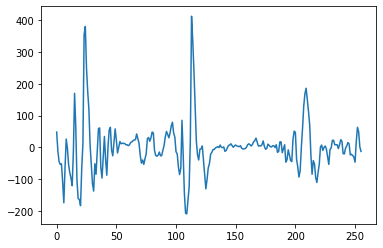

In [144]:
plt.plot(x[7,:,4])

In [87]:
DWT=dp.compute_DWT(x)
#ss = sc.fit_transform(np.array(DWT))

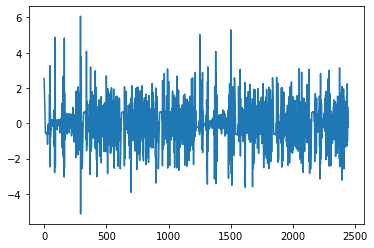

In [92]:
plt.plot(np.array(DWT[1]))
#np.array(DWT).shape

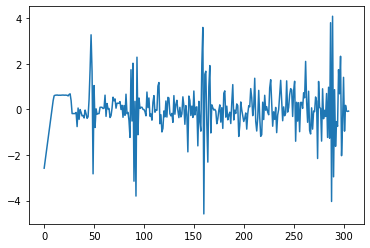

In [84]:
sc=StandardScaler()
wa = pywt.wavedec(x[0,:,0],'db7',3)
plt.plot(standard(wa))

In [49]:
cwtmatr,f = pywt.cwt(data[:1000],np.arange(1,63+1),'mexh')

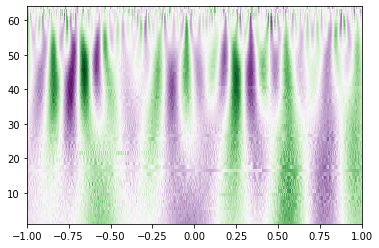

In [50]:
plt.imshow(cwtmatr, extent=[-1, 1, 1, 64], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show() # doctest: +SKIP

In [37]:
cwt = compute_CWT_feature(x)

In [45]:
    columns = pd.Index(['LEFT_TA', 'LEFT_TS', 'LEFT_BF', 'LEFT_RF',
       'RIGHT_TA', 'RIGHT_TS', 'RIGHT_BF', 'RIGHT_RF'])
    columns_b = ['_mean_coe','_min_coe','_mean_scale','_median_scale']
    index = []
    columns_b = pd.Index(columns_b)
    for col in columns:
        index += (col+columns_b).to_list()

In [122]:
dp.mDWT(x[7,:,4],'db7',2)

5


[456.42407,
 308.34598,
 236.15036,
 152.94284,
 107.79187,
 48.0118,
 24.006,
 12.003]

In [4]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [62]:
ind = (Y==1)|(Y==2)|(Y==6)
pd.Series(Y).value_counts()
print(len(Y[ind])/10*8)
Y1 = Y[ind]
pd.Series(Y1[8527:]).value_counts()
XX = X[ind]

TypeError: object of type 'int' has no len()

In [42]:
#xx = []
for i in range(len(XX)-1):
    if i == 0:
        xx = np.concatenate([XX[i][:64],XX[i+1][:64]])
    else:
        xx = np.concatenate([xx,XX[i+1][:64]])
        print(xx.shape)
        #print(len(xx))

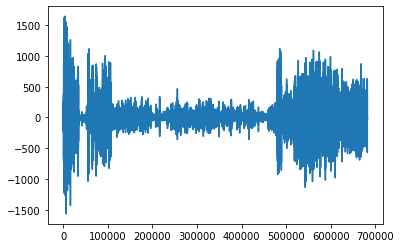

In [75]:
plt.plot(xx[:,0])

In [51]:
np.concatenate([XX[1][:2],XX[2][:2]]).shape

(4, 8)

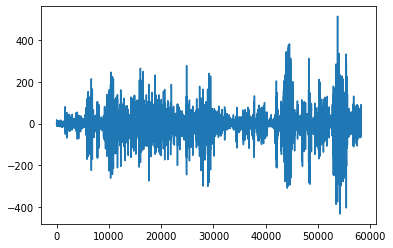

In [74]:
ind = (emg_data.Label1 == emg_data.Label2)
plt.plot(np.array(emg_data)[ind,4])

In [63]:
X=pd.DataFrame(X)
Y=pd.DataFrame(Y,columns=['label'])
dd = Y.join(X)
ind = (dd.label==1)|(dd.label==2)|(dd.label==6)
dd1 = dd.loc[ind,:].reset_index(drop=True)
dd2 = dd1.iloc[950000:,:].reset_index(drop=True)

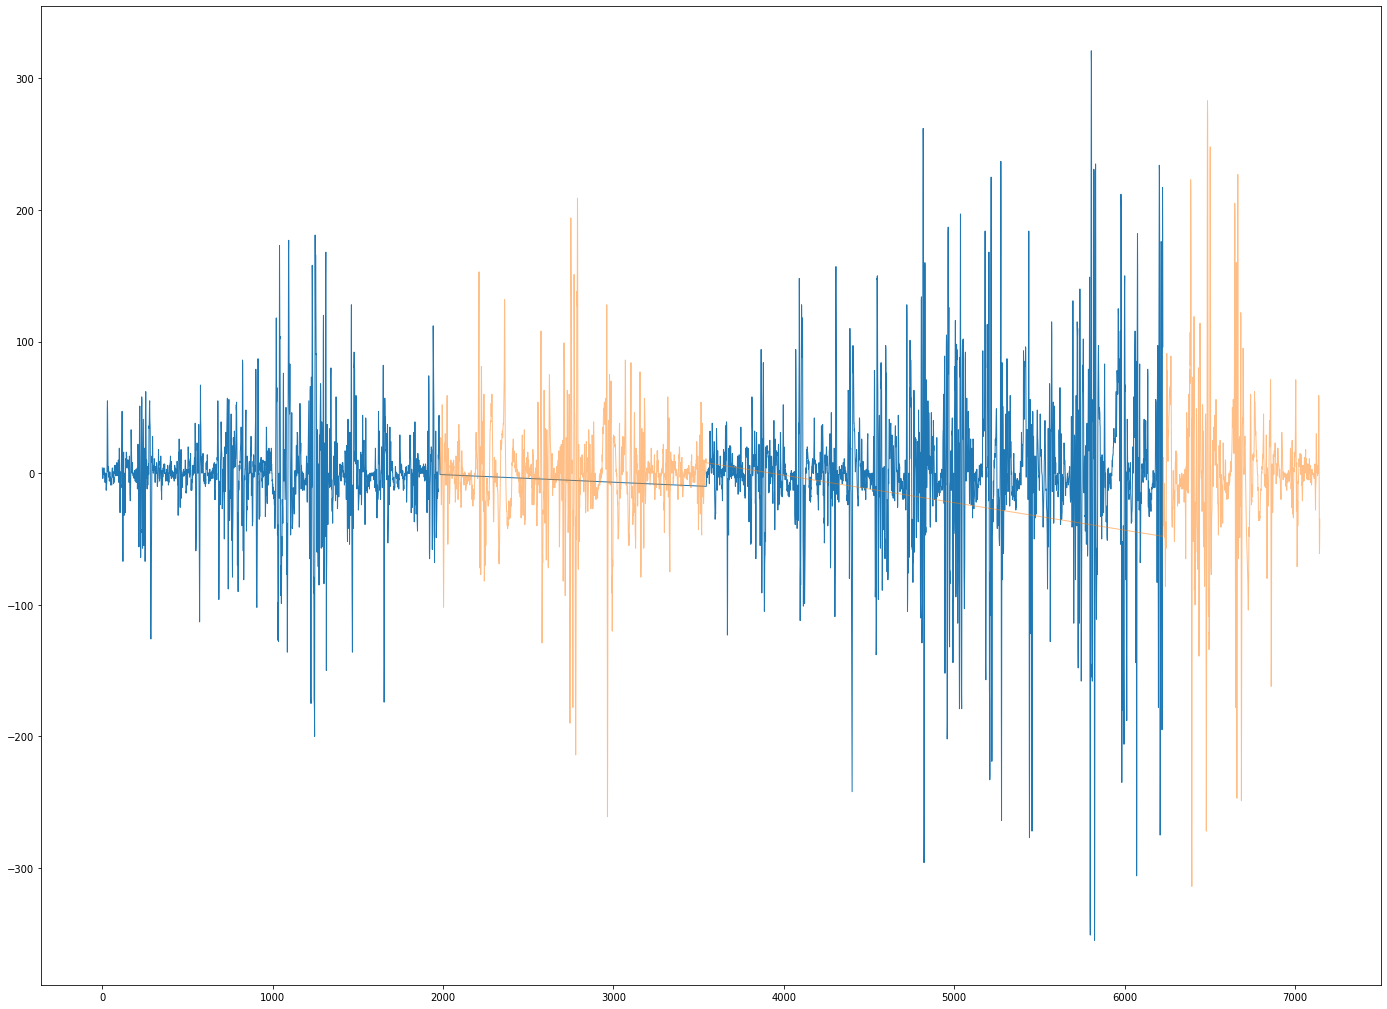

In [65]:
ind1 = (dd2.label==1)
ind2 = (dd2.label==2)
ind3 = (dd2.label==6)
plt.figure(figsize=(24,18))
plt.plot(dd2.loc[ind1,1],linewidth=1)
plt.plot(dd2.loc[ind2,1],alpha=0.5,linewidth=1)
plt.plot(dd2.loc[ind3,1],alpha=0.5,linewidth=1)

In [69]:
T=1e-3
i = 1

fn = 200
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
x_filter = signal.filtfilt(b, a, dd.iloc[i*90000:(i+1)*90000,1])

yf = fft(np.array(dd.iloc[i*90000:(i+1)*90000,1]))
N = len(np.array(dd.iloc[i*90000:(i+1)*90000,1]))
yff = 2.0/N * np.abs(yf[0:N//2])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

yf2 = fft(x_filter)
yff2 = 2.0/N * np.abs(yf2[0:N//2])

In [232]:
emg_data = pd.read_csv('.\\data\\P812_M050_2_B_FoG_trial_1_emg.csv')
emg_data = emg_data.dropna().reset_index(drop=True)
emg_data = abs(emg_data)

In [233]:
#for i in ['LEFT_TA','LEFT_TS','LEFT_BF','LEFT_RF','RIGHT_TA','RIGHT_TS','RIGHT_BF','RIGHT_RF']:
    #emg_data.loc[:,i] = signal.filtfilt(b, a, emg_data.loc[:,i])

In [258]:
fn = 20
wn=2*fn/1000
fn1 = 400
wn1 = 2*fn1/1000
b, a = signal.butter(4, wn, 'lowpass')
data=emg_data.iloc[:,3]
x_filter1 = signal.filtfilt(b, a, data)
x_filter = ndimage.median_filter(data, size=50)*2
yf = fft(np.array(data))
N = len(np.array(data))
yff = 2.0/N * np.abs(yf[0:N//2])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
yf2 = fft(x_filter)
yff2 = 2.0/N * np.abs(yf2[0:N//2])

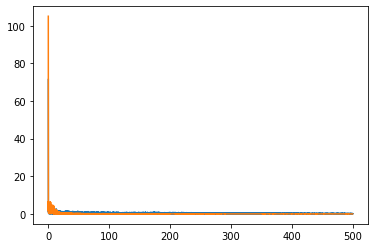

In [259]:
plt.plot(xf,yff)
plt.plot(xf,yff2)

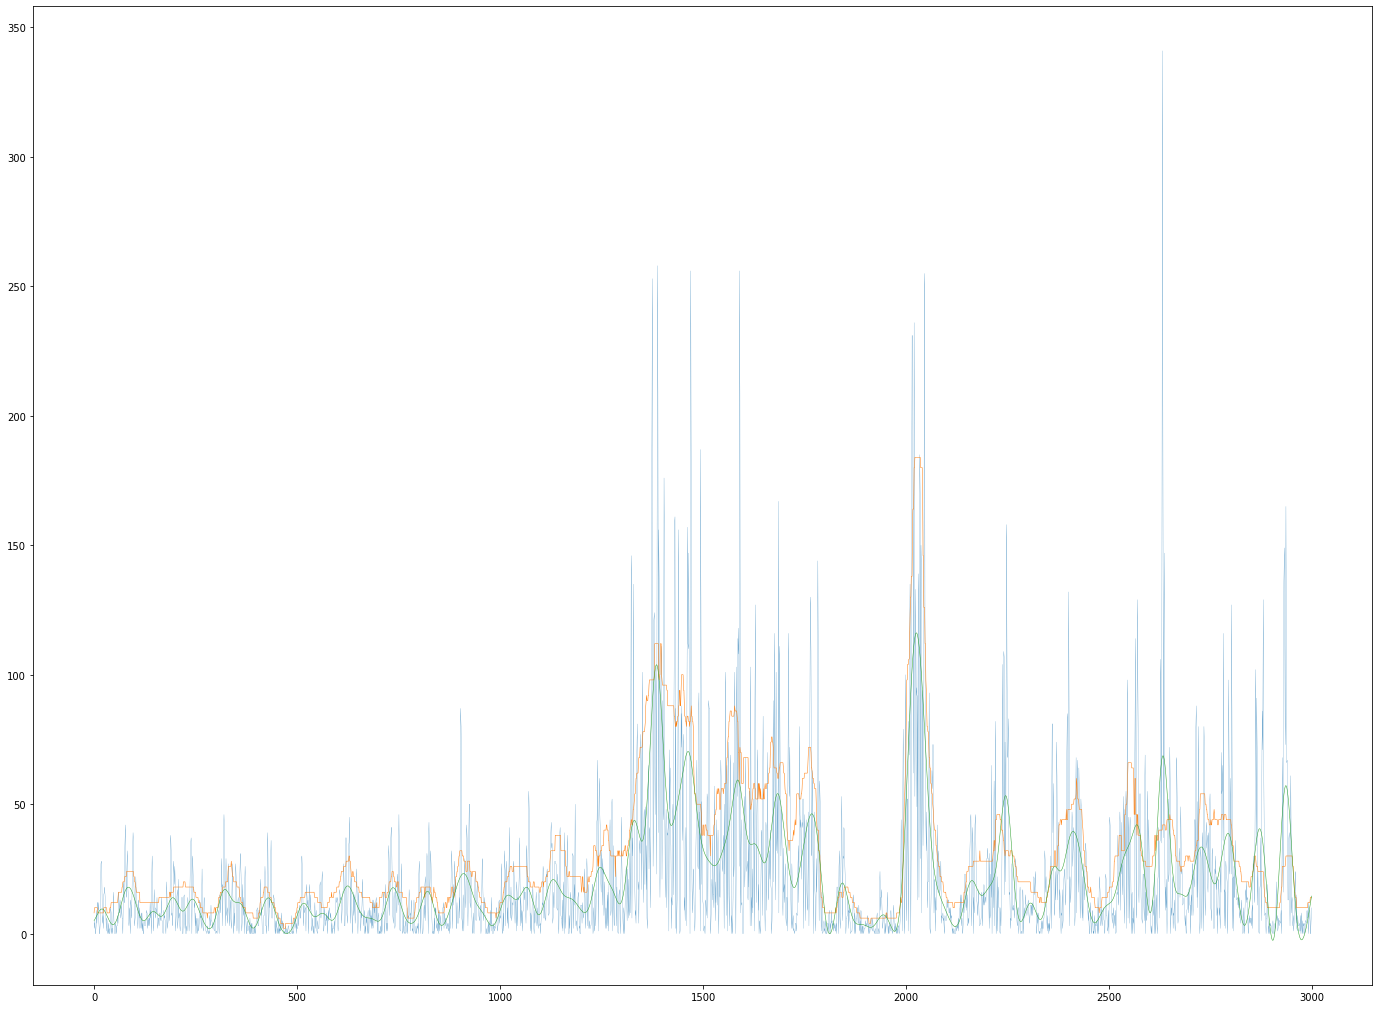

In [260]:
plt.figure(figsize=(24,18))
plt.plot(np.array(data)[2000:5000],linewidth=0.2)
plt.plot(x_filter[2000:5000],linewidth=0.5)
plt.plot(x_filter1[2000:5000],linewidth=0.5)

2    33522
6    23441
1    19858
0    13179
Name: label, dtype: int64


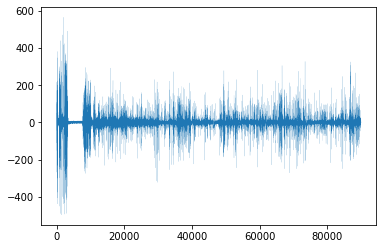

In [266]:
plt.plot(np.array(dd.iloc[i*90000:(i+1)*90000,1]),linewidth=0.1)
print(dd.iloc[i*90000:(i+1)*90000,0].value_counts())

In [258]:
np.mean(np.array(dd.iloc[i*90000:(i+1)*90000,1]))

-0.17976666666666666

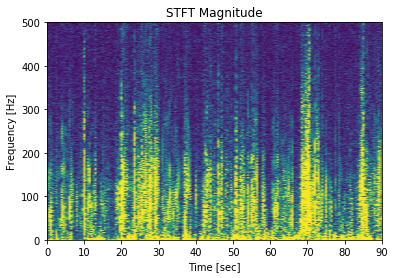

In [256]:
fs = 1e3
f, t, Zxx = signal.stft(np.array(dd.iloc[i*90000:(i+1)*90000,1]), fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

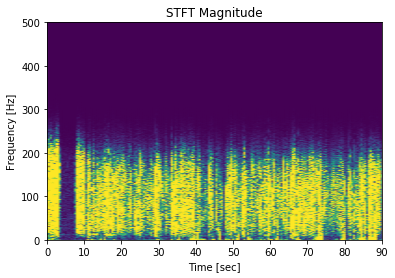

In [321]:
fs = 1e3
f, t, Zxx = signal.stft(x_filter, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [303]:
threshold = 0.1 # Threshold for filtering
# Decompose into wavelet components, to the level selected:

coeffs = pywt.wavedec(x[1,:,1], 'db8') # 将信号进行小波分解
for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) # 将噪声滤波
    datarec = pywt.waverec(coeffs, 'db8')

In [309]:
fn = 200
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
x_filter = signal.filtfilt(b, a, x[1,:,1])

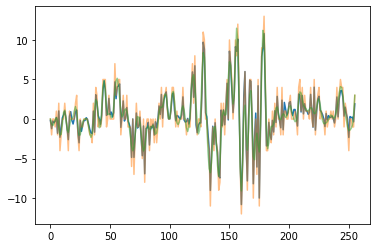

In [310]:
plt.plot(datarec)
plt.plot(x[1,:,1],alpha=0.5)
plt.plot(x_filter,alpha=0.5)

In [311]:
datarec.mean()

0.43486488

In [104]:
temp=normalize(x[5,:,:3],axis=0,norm='l2')
temp2=normalize(x[5,:,:3],axis=0,norm='l1')

In [81]:
temp,y=dp.generate_window_slide_data(emg_data,width = 256,stride = 64,scaler=True,same_label=True)

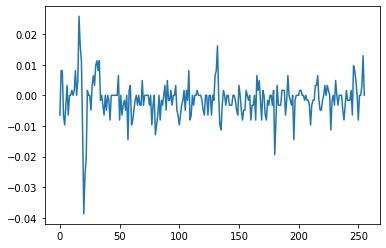

In [107]:
#temp=np.array(temp)
temp.min()
plt.plot(temp2[:,1])
#plt.plot(temp[:,1])

In [7]:
np.clip([600,3-503],-500,500)

array([ 500, -500])